# Reading image files

In [1]:
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

In [2]:
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0  20.0M      0  0:00:13  0:00:13 --:--:-- 23.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  14.9M      0  0:00:05  0:00:05 --:--:-- 19.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99620  100 99620    0     0  86101      0  0:00:01  0:00:01 --:--:-- 86101


In [3]:
!unzip GTSRB_Final_Training_Images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: GTSRB/Final_Training/Images/00035/00000_00019.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating:

In [4]:
#TRAINING_CSV_PATH = '../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*/*.csv'

#Sur collab : 
TRAINING_CSV_PATH = './GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [5]:
os.path.dirname(TRAINING_CSV_PATH)

'./GTSRB/Final_Training/Images/*'

In [6]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [7]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,35,30,6,5,30,25,2,./GTSRB/Final_Training/Images/00002/00000_0000...
1,00000_00001.ppm,35,31,5,5,30,26,2,./GTSRB/Final_Training/Images/00002/00000_0000...
2,00000_00002.ppm,35,31,5,5,30,26,2,./GTSRB/Final_Training/Images/00002/00000_0000...
3,00000_00003.ppm,37,33,6,6,32,28,2,./GTSRB/Final_Training/Images/00002/00000_0000...
4,00000_00004.ppm,37,33,6,6,32,28,2,./GTSRB/Final_Training/Images/00002/00000_0000...


In [8]:
# Reading only 200 images for the moment
images_list = build_images_list(images_df.head(200)['path'].values,
                                images_df.head(200).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)

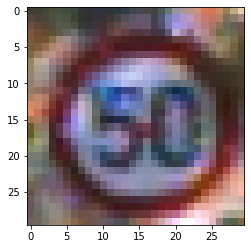

In [9]:
plt.imshow(images_list[190])

In [10]:
build_classes_array(images_df)

array([ 2,  2,  2, ..., 16, 16, 16])

In [11]:
images_df['ClassId'].value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
Name: ClassId, dtype: int64

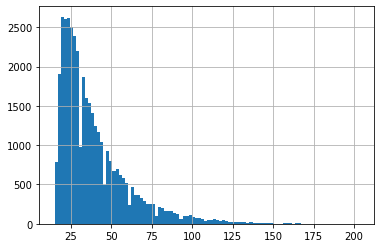

In [12]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [13]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

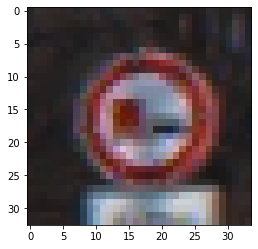

In [14]:
img = Image.open('./GTSRB/Final_Training/Images/00010/00029_00010.ppm')
plt.imshow(img)

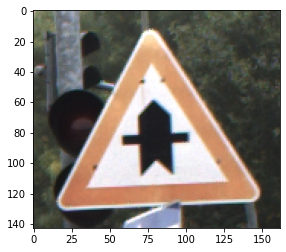

In [15]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

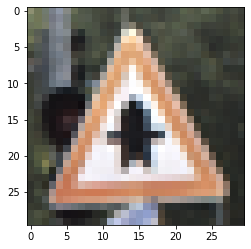

In [16]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

In [17]:
images_df.head(1)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,35,30,6,5,30,25,2,./GTSRB/Final_Training/Images/00002/00000_0000...


In [18]:
img = Image.open('./GTSRB/Final_Training/Images/00010/00005_00029.ppm')

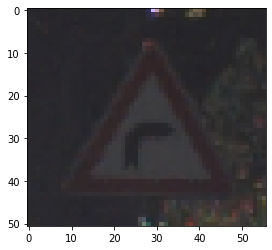

In [19]:
plt.imshow(Image.open(images_df.query('ClassId == 20').iloc[20]['path']))

## Training the model

In [22]:
import datetime
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

#### Take a sample to test the code

In [23]:
images_df.shape

(39209, 9)

In [24]:
N = 10_000
N = None #Take all


if N is None:

  images_list = build_images_list(images_df['path'].values,
                                images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)

else : 
  images_list = build_images_list(images_df.head(N)['path'].values,
                                images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]


print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [25]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [26]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [27]:
# Connexion vers une TPU Google
try :
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.66.80.226:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.66.80.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.66.80.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [28]:
# Recompilation du modèle
with tpu_strategy.scope():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

In [29]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [30]:
#Converting the labels into one hot encoding
%%time


epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
#model.save("my_model.h5")

Epoch 1/15
981/981 [==============================] - 25s 25ms/step - loss: 3.0236 - accuracy: 0.4306 - val_loss: 0.3523 - val_accuracy: 0.9174
Epoch 2/15
981/981 [==============================] - 24s 25ms/step - loss: 0.3780 - accuracy: 0.9025 - val_loss: 0.0836 - val_accuracy: 0.9797
Epoch 3/15
981/981 [==============================] - 23s 24ms/step - loss: 0.2500 - accuracy: 0.9371 - val_loss: 0.0853 - val_accuracy: 0.9791
Epoch 4/15
981/981 [==============================] - 24s 24ms/step - loss: 0.2099 - accuracy: 0.9471 - val_loss: 0.0904 - val_accuracy: 0.9815
Epoch 5/15
981/981 [==============================] - 23s 24ms/step - loss: 0.2224 - accuracy: 0.9440 - val_loss: 0.0375 - val_accuracy: 0.9909
Epoch 6/15
981/981 [==============================] - 24s 24ms/step - loss: 0.1349 - accuracy: 0.9664 - val_loss: 0.0467 - val_accuracy: 0.9874
Epoch 7/15
981/981 [==============================] - 23s 24ms/step - loss: 0.1453 - accuracy: 0.9649 - val_loss: 0.0594 - val_accuracy:

### Plot model accuracy & loss

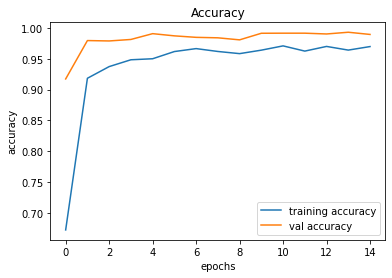

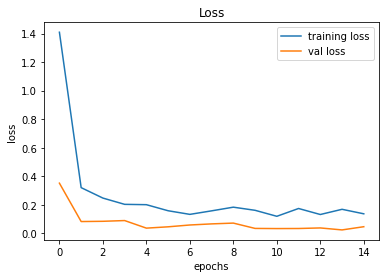

In [31]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


### Save classifier

In [32]:
def save_classifier(model, basename):
  """ Save to H5 format a TF model with timestamp

  Parameters
  -----
  model: trained tf model
  basename : basename including path to use for filename


  Returns
  ------
  None
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%M-%d_%H-%M-%S')))
  return

In [33]:
save_classifier(model, "models/traffic_signs")

## Testing model

In [34]:
def classify_image(path, model, image_box=None):
  """Classify image by model
​
  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier
​
  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict_classes(np.array(images_list))

In [35]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
classify_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([15])

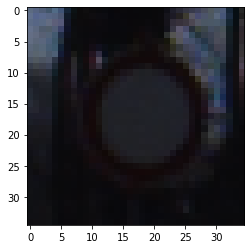

In [36]:
# Affichage de l'image
plt.imshow(Image.open(image_sample['path'].values[0]))

## Reloading model


In [38]:
test_model = load_model('models/traffic_signs_2021-19-31_13-19-49.h5')

In [39]:
# Tirage aléatoire d'une image
image_sample = images_df.sample(1)
classify_image(image_sample['path'].values[0],
               test_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([28])

### Evaluating performance

#### Extracting test data

In [40]:
!unzip -q GTSRB_Final_Test_Images.zip

In [41]:
!unzip -q GTSRB_Final_Test_GT.zip

#### Load text data

In [42]:
test_images_df = pd.read_csv('GT-final_test.csv', sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x:'./GTSRB/Final_Test/Images/' + x) 
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,./GTSRB/Final_Test/Images/12625.ppm
12626,12626.ppm,50,51,6,5,45,46,33,./GTSRB/Final_Test/Images/12626.ppm
12627,12627.ppm,29,29,6,6,24,24,6,./GTSRB/Final_Test/Images/12627.ppm
12628,12628.ppm,48,49,5,6,43,44,7,./GTSRB/Final_Test/Images/12628.ppm
12629,12629.ppm,32,31,6,5,27,26,10,./GTSRB/Final_Test/Images/12629.ppm


In [43]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)


In [44]:
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


In [57]:
%%time 
results = test_model.predict_classes(test_data)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 327 ms, sys: 59.6 ms, total: 387 ms
Wall time: 1.58 s


In [46]:
test_labels[:3]

array([16,  1, 38])

In [47]:
test_labels == results

array([ True,  True,  True, ..., False,  True,  True])

In [48]:
np.transpose(results)

array([16,  1, 38, ..., 41,  7, 10])

#### Compare actual to predicted 

In [49]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels 
accuracy_df['predicted']= results

In [50]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


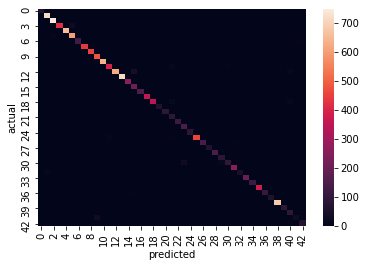

In [51]:
import seaborn as sns

sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted']))

In [52]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'])

predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,717,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,748,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,2,419,0,24,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,658,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,5,11,3,4,602,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,4,2,1,0,2,126,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,3,8
7,0,2,3,0,2,0,0,436,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


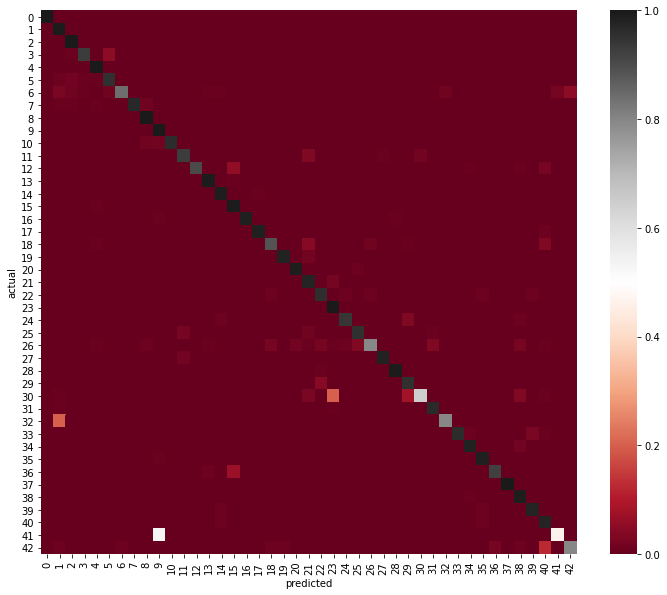

In [53]:
import seaborn as sns

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'],normalize="index"), 
            cmap="RdGy",
            ax = ax);